In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from zipfile import ZipFile
from tensorflow.keras.utils import load_img, img_to_array
import random
import tensorflow as tf
random.seed(10)
print(random.seed(10))

None


In [2]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [3]:

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [7]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

In [22]:
# Baixando dataset e manipulando
dataset_dir = os.path.join(os.getcwd(), r'C:\Users\Setup\Downloads\Autoencoder')

dataset_train_dir = os.path.join(dataset_dir, r'C:\Users\Setup\Downloads\Autoencoder\coloridas' )
dataset_train_color_len = len(os.listdir(os.path.join(dataset_train_dir, r'C:\Users\Setup\Downloads\Autoencoder - Copia\train\colorido')))

print('Imagem colorido: %s' % dataset_train_color_len)



Imagem colorido: 3024


In [25]:

train_datagen = ImageDataGenerator(rescale=1. / 255)


train = train_datagen.flow_from_directory(r'C:\Users\Setup\Downloads\dataset_teste', 
                                          target_size=(256,256), 
                                          batch_size=340, 
                                          class_mode=None)


Found 4319 images belonging to 1 classes.


In [26]:
from skimage.color import rgb2lab, lab2rgb
X =[]
Y =[]
for img in train[0]:
  try:
      lab = rgb2lab(img)
      X.append(lab[:,:,0]) 
      Y.append(lab[:,:,1:] / 128) #A and B values range from -127 to 128, 
      #so we divide the values by 128 to restrict values to between -1 and 1.
  except:
     print('error')
X = np.array(X)
Y = np.array(Y)
X = X.reshape(X.shape+(1,)) #dimensions to be the same for X and Y
print(X.shape)
print(Y.shape)

(340, 256, 256, 1)
(340, 256, 256, 2)


In [27]:
# Encoder
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2, input_shape=(256, 256, 1)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))

In [29]:
from keras.layers import Conv2D, UpSampling2D
#Decoder
#Note: For the last layer we use tanh instead of Relu. 
#This is because we are colorizing the image in this layer using 2 filters, A and B.
#A and B values range between -1 and 1 so tanh (or hyperbolic tangent) is used
#as it also has the range between -1 and 1. 
#Other functions go from 0 to 1.
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='adam', loss='mse' , metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 256)       295168    
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 256)       590080    
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 512)       1180160   
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 512)       2

In [30]:
model.fit(X,Y,validation_split=0.1, epochs=5, batch_size=16)

Epoch 1/5
20/20 [==============================] - 110s 5s/step - loss: 0.1415 - accuracy: 0.4964 - val_loss: 0.0198 - val_accuracy: 0.5378
Epoch 2/5
20/20 [==============================] - 86s 4s/step - loss: 0.0177 - accuracy: 0.5031 - val_loss: 0.0197 - val_accuracy: 0.5261
Epoch 3/5
20/20 [==============================] - 83s 4s/step - loss: 0.0176 - accuracy: 0.5339 - val_loss: 0.0199 - val_accuracy: 0.5207
Epoch 4/5
20/20 [==============================] - 83s 4s/step - loss: 0.0186 - accuracy: 0.5170 - val_loss: 0.0200 - val_accuracy: 0.5400
Epoch 5/5
20/20 [==============================] - 82s 4s/step - loss: 0.0187 - accuracy: 0.4899 - val_loss: 0.0202 - val_accuracy: 0.4825


In [40]:
model.save('colorize_autoencoder.model')

INFO:tensorflow:Assets written to: colorize_autoencoder.model\assets


INFO:tensorflow:Assets written to: colorize_autoencoder.model\assets


1/1 [==============================] - 0s 110ms/step


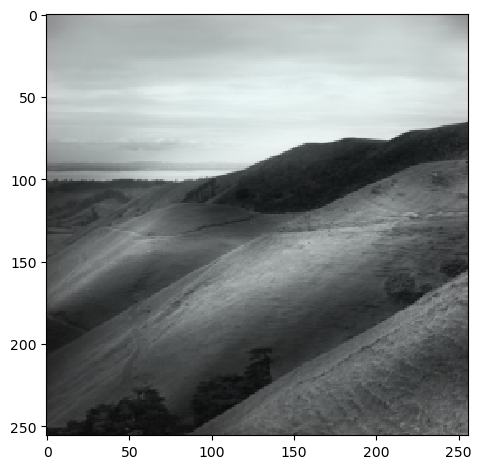

In [55]:
from keras.layers import Conv2D, UpSampling2D
from keras.models import Sequential

from skimage.color import rgb2lab, lab2rgb
from skimage.transform import resize
from skimage.io import imsave, imshow
import numpy as np
import tensorflow as tf

tf.keras.models.load_model(
    r'colorize_autoencoder.model',
    custom_objects=None,
    compile=True)

img1_color=[]

img1=img_to_array(load_img(r"C:\Users\Setup\Downloads\Autoencoder\coloridas\00000000.jpg"))
img1 = resize(img1 ,(256,256))
img1_color.append(img1)

img1_color = np.array(img1_color, dtype=float)
img1_color = rgb2lab(1.0/255*img1_color)[:,:,:,0]
img1_color = img1_color.reshape(img1_color.shape+(1,))

output1 = model.predict(img1_color)
output1 = output1*128

result = np.zeros((256, 256, 3))
result[:,:,0] = img1_color[0][:,:,0]
result[:,:,1:] = output1[0]
imshow(lab2rgb(result))
#imsave("result.png", lab2rgb(result))